In [12]:
import torch, librosa
from demucs.pretrained import get_model
import soundfile as sf
from faster_whisper import WhisperModel
import pandas as pd
import re

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import utils

from IPython.display import Audio

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_demucs = get_model(name='htdemucs').to(device)
model_whisper = WhisperModel("small", device="cuda", compute_type="float16")

In [14]:
def getSpecificAudioPart(audio, sr, start_sec, end_sec):
    start = int(start_sec * sr)
    end = int(end_sec * sr)
    audio_segment = audio[:, :, start:end]

    return audio_segment


def changeAudio2Dto1D(audio):
    return audio.mean(axis=0, keepdims=True)


def split_audio_array(audio_np, chunk_size=1, sr=16000, output_dir="./chunk"):
    """
    전체 오디오를 chunk_size (초) 단위로 나누어 저장

    @param audio_np: (N,) 또는 (1, N) 또는 (2, N) 형태의 numpy 오디오 배열
    @param chunk_size: 청크 크기 (초 단위)
    @param sr: 샘플링 레이트
    @param output_dir: 청크를 저장할 폴더
    @return: [(시작초, 끝초, 파일경로), ...]
    """
    os.makedirs(output_dir, exist_ok=True)

    if audio_np.ndim == 2:
        audio_np = audio_np.squeeze()  # (1, N) 또는 (2, N) → (N,)

    total_samples = audio_np.shape[-1]
    total_duration = total_samples / sr
    chs = []

    print("🎧 청크 분할 중...")
    t = 0
    while t < total_duration:
        start_sample = int(t * sr)
        end_sample = int(min(t + chunk_size, total_duration) * sr)
        chunk = audio_np[start_sample:end_sample]

        chunk_path = os.path.join(output_dir, f"chunk_{int(t)}_{int(t+chunk_size)}.wav")
        sf.write(chunk_path, chunk, sr)
        chs.append((t, t + chunk_size, chunk_path))
        t += chunk_size

    print(f"✅ 총 {len(chs)}개의 청크 저장 완료")
    return chs

def tempo_trans(audio, trans_tempo, origin_tempo):
    tempo = trans_tempo / origin_tempo
    audio_stretched = librosa.effects.time_stretch(audio, rate = tempo)
    return audio_stretched


- https://www.youtube.com/watch?v=krbAObQIOIU
- 말 소리 완전 빨랐어요. 칙칙폭폭 짱빨랐음. 1.5배 이상으로 빠른 것 같아요. 장면 전환도 빠르고
- time: 76
- speed: 1.2

---

- https://www.youtube.com/watch?v=LojS2Gokliw
- 말하는 사람의 말이 몇 초 전과 비교했을때 갑자기 빨라짐(1.3배속 예상)
- time: 83
- speed: 1.3

---

- https://www.youtube.com/watch?v=GMPEAL6PL2k
- 처음부터 말을 너무 빠르게 했음
- time: 2
- speed: 1.3

---

- https://www.youtube.com/watch?v=iR2qhUOmZ7U
- 말의 속도가 빠름
- time: 41
- speed: 1.15

---

- https://www.youtube.com/watch?v=HaYNqWBaanI
- 말이 좀 빠른 것 같음
- time: 24
- speed: 1

---

- https://www.youtube.com/watch?v=GVVHwB9YaxA&t=810s&ab_channel=%EC%BD%94%EB%94%A9%EC%9B%A8%EC%9D%BC%F0%9F%90%B3%28%EC%9E%90%EC%8B%A0%29
- 응답 X
- time: 546
- speed: 1.05

In [156]:
audio_url, speed = 'https://www.youtube.com/watch?v=LojS2Gokliw', 1.3

audio, sr = utils.getAudioCroppedFromURL(audio_url, isMono=False, sr=44100)

specific_audio = getSpecificAudioPart(audio, sr, 68, 88)

sources = utils.split_audio_to_speech_music(specific_audio, model_demucs)

In [157]:
bass = changeAudio2Dto1D(sources[0])
drums = changeAudio2Dto1D(sources[1])
other = changeAudio2Dto1D(sources[2])
vocal = changeAudio2Dto1D(sources[3])

others = bass + drums + other
all_audio = others + vocal
Audio(vocal, rate=sr)

In [158]:
Audio(others, rate=sr)

In [159]:
Audio(tempo_trans(vocal.squeeze(0).numpy(), speed, 1), rate=sr)

In [160]:
chunks = split_audio_array(
    vocal, chunk_size=5, sr=int(sr), output_dir="../response_chunk/5"
)

🎧 청크 분할 중...
✅ 총 4개의 청크 저장 완료


In [161]:
result = utils.estimate_articulation_rate_fast_whisper(chunks, model_whisper, 30)

df = pd.DataFrame(result)
df['speedup_articulation_rate'] = round(df['articulation_rate'] * speed, 2)
df

조음 속도 계산 진행중...


Processing chunks: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


start  end                             text  chars  speech_duration  \
0      0    5            자저는근본캐릭터말이요여기차가굉장히많아요     21            3.642   
1      5   10      차종류별로몸빵은되는데스피드는느린차스피드는빠른데몸빵     27            4.385   
2     10   15  상은약한차이렇게나뉘는것같더라고요저는바이크를한번타보겠습니다     31            3.971   
3     15   20            바이크생긴거봐이게사나이의심장을울려자보자     21            3.889   

   articulation_rate  speedup_articulation_rate  
0               5.77                       7.50  
1               6.16                       8.01  
2               7.81                      10.15  
3               5.40                       7.02

🎤 평균 피치(F₀): 177.84 Hz


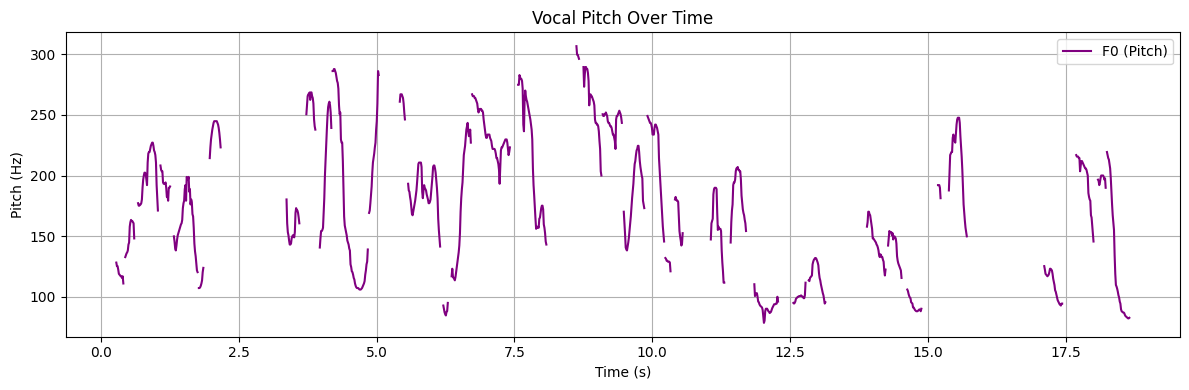

In [162]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# librosa는 mono 신호를 원하니까 1D 오디오 사용
# f0 = librosa.yin(
#     y=vocal.numpy(),
#     fmin=50,        # 너무 낮은 피치는 무시 (남성 보이스 최소 80~100Hz)
#     fmax=500,       # 너무 높은 피치는 무시 (여성/가성 포함)
#     sr=sr
# )

f0, voiced_flag, voiced_probs = librosa.pyin(
    y=vocal.numpy(),
    fmin=50,
    fmax=500,
    sr=sr
)

# nan 값 제외하고 평균 피치 구하기
mean_pitch = np.nanmean(f0)
print(f"🎤 평균 피치(F₀): {mean_pitch:.2f} Hz")

# ⏱️ 시간 축 계산
times = librosa.times_like(f0, sr=sr)

# 📊 피치 시각화
plt.figure(figsize=(12, 4))
plt.plot(times, f0.squeeze(0), label="F0 (Pitch)", color="purple")
plt.xlabel("Time (s)")
plt.ylabel("Pitch (Hz)")
plt.title("Vocal Pitch Over Time")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


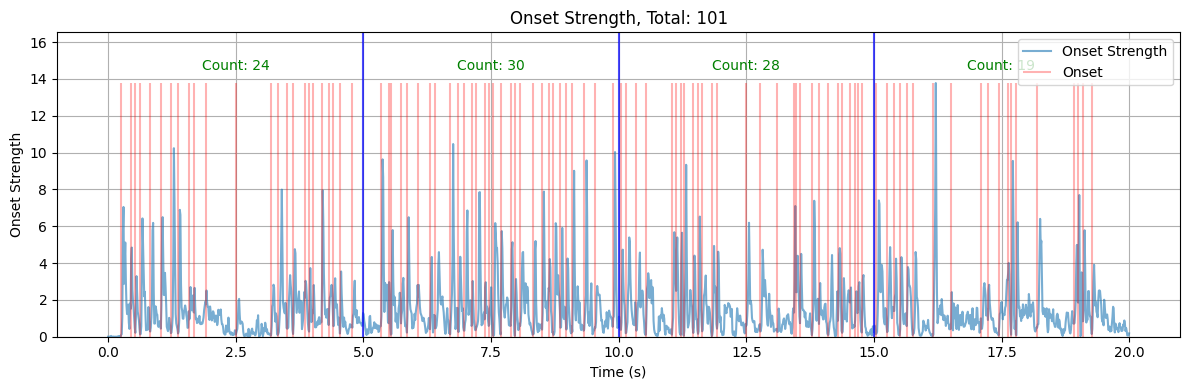

In [163]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Onset Strength 계산
onset_env = librosa.onset.onset_strength(
    y=vocal.numpy(),
    sr=sr,
)

# 시간축 생성
frames = np.arange(len(onset_env[0]))
times = librosa.frames_to_time(frames, sr=sr)

# onset_detect
onset_frames = librosa.onset.onset_detect(
    y=vocal.squeeze(0).numpy(),
    sr=sr,
    pre_max=3,
    post_max=3,
    pre_avg=9,
    post_avg=6,
    wait=3,
)

onset_times = librosa.frames_to_time(onset_frames, sr=sr)

# Backtrack
onset_backtracked = librosa.onset.onset_backtrack(onset_frames, onset_env[0])
backtracked_times = librosa.frames_to_time(onset_backtracked, sr=sr)

# ➕ 4등분: 각 구간에서 onset 개수 계산
total_duration = times[-1]
segment_edges = np.linspace(0, total_duration, 5)  # 4등분
onset_counts = []

for i in range(4):
    start = segment_edges[i]
    end = segment_edges[i + 1]
    count = np.sum((backtracked_times >= start) & (backtracked_times < end))
    onset_counts.append(count)

# 🎨 시각화
plt.figure(figsize=(12, 4))
plt.plot(times, onset_env.squeeze(0), label="Onset Strength", alpha=0.6)

# Onset 위치
plt.vlines(
    backtracked_times,
    0,
    np.max(onset_env),
    color="r",
    linestyle="-",
    label="Onset",
    alpha=0.3
)

# 📊 구간별 onset 개수 텍스트
for i in range(4):
    midpoint = (segment_edges[i] + segment_edges[i + 1]) / 2
    plt.text(midpoint, np.max(onset_env) * 1.05, f"Count: {onset_counts[i]}", 
             ha='center', fontsize=10, color="green")

# ➖ 4등분 경계선 표시 (0은 생략)
for edge in segment_edges[1:-1]:  # 시작/끝 제외 중간 3개만 표시
    plt.axvline(x=edge, color="blue", linestyle="-", alpha=0.7)

# 세팅
plt.title(f"Onset Strength, Total: {len(onset_frames)}")
plt.xlabel("Time (s)")
plt.ylabel("Onset Strength")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.ylim(0, np.max(onset_env) * 1.2)
plt.show()


### 음악

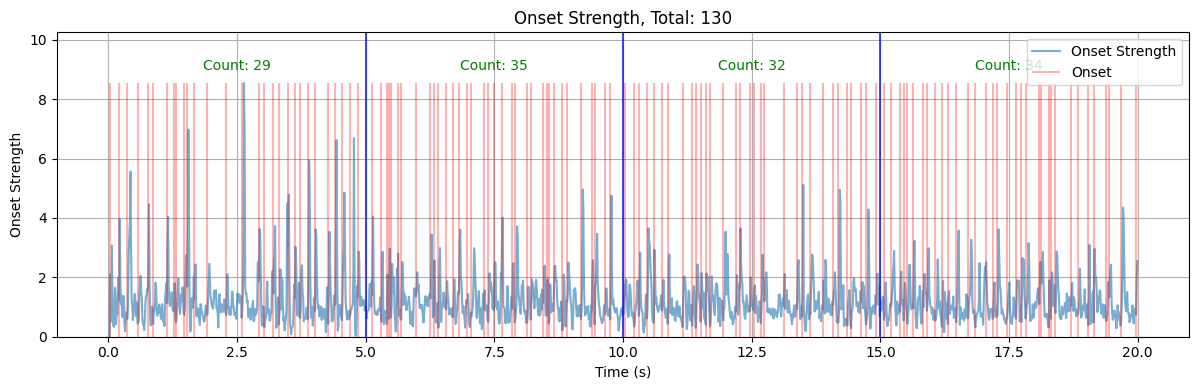

In [164]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Onset Strength 계산
onset_env = librosa.onset.onset_strength(
    y=others.numpy(),
    sr=sr,
)

# 시간축 생성
frames = np.arange(len(onset_env[0]))
times = librosa.frames_to_time(frames, sr=sr)

# onset_detect
onset_frames = librosa.onset.onset_detect(
    y=others.squeeze(0).numpy(),
    sr=sr,
    pre_max=3,
    post_max=3,
    pre_avg=9,
    post_avg=6,
    wait=3,
)

onset_times = librosa.frames_to_time(onset_frames, sr=sr)

# Backtrack
onset_backtracked = librosa.onset.onset_backtrack(onset_frames, onset_env[0])
backtracked_times = librosa.frames_to_time(onset_backtracked, sr=sr)

# ➕ 4등분: 각 구간에서 onset 개수 계산
total_duration = times[-1]
segment_edges = np.linspace(0, total_duration, 5)  # 4등분
onset_counts = []

for i in range(4):
    start = segment_edges[i]
    end = segment_edges[i + 1]
    count = np.sum((backtracked_times >= start) & (backtracked_times < end))
    onset_counts.append(count)

# 🎨 시각화
plt.figure(figsize=(12, 4))
plt.plot(times, onset_env.squeeze(0), label="Onset Strength", alpha=0.6)

# Onset 위치
plt.vlines(
    backtracked_times,
    0,
    np.max(onset_env),
    color="r",
    linestyle="-",
    label="Onset",
    alpha=0.3
)

# 📊 구간별 onset 개수 텍스트
for i in range(4):
    midpoint = (segment_edges[i] + segment_edges[i + 1]) / 2
    plt.text(midpoint, np.max(onset_env) * 1.05, f"Count: {onset_counts[i]}", 
             ha='center', fontsize=10, color="green")

# ➖ 4등분 경계선 표시 (0은 생략)
for edge in segment_edges[1:-1]:  # 시작/끝 제외 중간 3개만 표시
    plt.axvline(x=edge, color="blue", linestyle="-", alpha=0.7)

# 세팅
plt.title(f"Onset Strength, Total: {len(onset_frames)}")
plt.xlabel("Time (s)")
plt.ylabel("Onset Strength")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.ylim(0, np.max(onset_env) * 1.2)
plt.show()
